In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import json
from PIL import Image

In [4]:
import cv2
from IPython.display import display, Image

def draw_annotation(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    
    # Extract the annotation details
    filename = annotation["FileName"]
    annotations = annotation["Annotations"]
    
    # Process each annotation
    for annot in annotations:
        bounding_box = annot["BoundingBox"]
        class_name = annot["classname"]
        
        # Draw the bounding box
        x_min, y_min, x_max, y_max = bounding_box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Add the class label
        text = f"{class_name}"
        cv2.putText(image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Save the image with annotations
    annotated_image_path = "annotated_image.jpg"
    cv2.imwrite(annotated_image_path, image)
    
    # Display the image in the notebook
    display(Image(filename=annotated_image_path))


{'FileName': '1805.jpg', 'NumOfAnno': 3, 'Annotations': [{'isProtected': False, 'ID': 9342941522608172, 'BoundingBox': [728, 180, 853, 336], 'classname': 'face_with_mask', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 309417090748452160, 'BoundingBox': [737, 249, 831, 320], 'classname': 'mask_surgical', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 456958880830800064, 'BoundingBox': [703, 164, 877, 277], 'classname': 'hat', 'Confidence': 1, 'Attributes': {}}]}


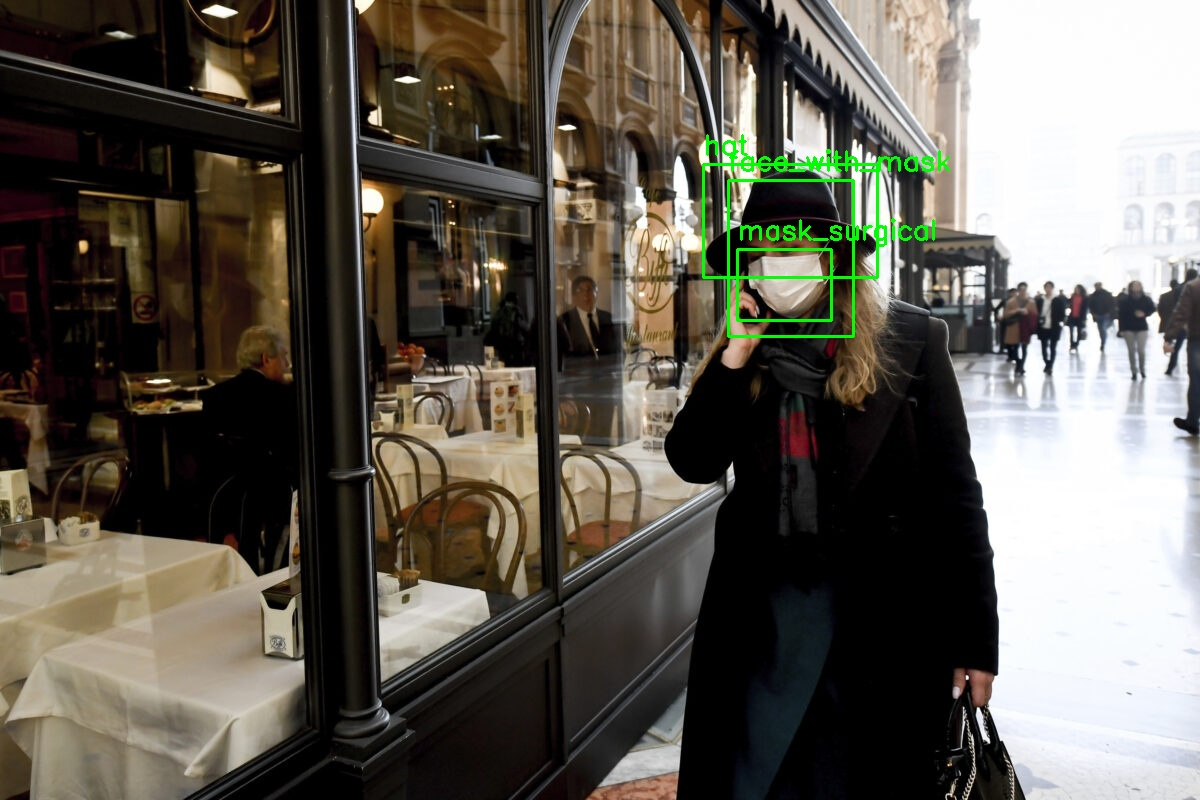

In [7]:
number = 1805


image_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images\\{number}.jpg".format(number=number)

#read json file
import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations\\{number}.jpg.json'.format(number=number)) as json_file:
    annotation = json.load(json_file)

print(annotation)

draw_annotation(image_path, annotation)

In [40]:
import os

class MaskDetectionDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.annotations = []
        self.load_annotations()

    def load_annotations(self):
        annotation_files = os.listdir(f"{self.root_dir}/annotations")
        for file_name in annotation_files:
            with open(f"{self.root_dir}/annotations/{file_name}", "r") as f:
                annotations = json.load(f)["Annotations"]
                self.annotations.extend(annotations)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        print(idx)
        annotation = self.annotations[idx]
        print("Annotation",annotation)
        image_path = f"{self.root_dir}/images/{annotation['FileName']}"
        image = Image.open(image_path).convert("RGB")

        # Convert bounding box coordinates to a format accepted by torchvision
        box = annotation["BoundingBox"]
        box = torch.tensor([box[0], box[1], box[2], box[3]], dtype=torch.float32)

        # Map class names to integer labels (e.g., 'face_with_mask' -> 1)
        class_name = annotation["classname"]
        class_label = 1 if class_name == "face_with_mask" else 0

        return {
            "image": image,
            "bbox": box,
            "label": class_label
        }


In [53]:
dataset = MaskDetectionDataset("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask")


# Split the dataset into training and validation sets (adjust the split ratio as needed)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [55]:
dataset.annotations

[{'isProtected': False,
  'ID': 924868908868875136,
  'BoundingBox': [451, 186, 895, 697],
  'classname': 'face_no_mask',
  'Confidence': 1,
  'Attributes': {}},
 {'isProtected': False,
  'ID': 514761005180314112,
  'BoundingBox': [110, 71, 273, 272],
  'classname': 'face_with_mask',
  'Confidence': 1,
  'Attributes': {}},
 {'isProtected': False,
  'ID': 811475433588006784,
  'BoundingBox': [160, 151, 268, 265],
  'classname': 'mask_surgical',
  'Confidence': 1,
  'Attributes': {}},
 {'isProtected': False,
  'ID': 878367304953179776,
  'BoundingBox': [126, 75, 303, 333],
  'classname': 'face_with_mask',
  'Confidence': 1,
  'Attributes': {}},
 {'isProtected': False,
  'ID': 12410823666672788,
  'BoundingBox': [147, 200, 288, 320],
  'classname': 'mask_surgical',
  'Confidence': 1,
  'Attributes': {}},
 {'isProtected': False,
  'ID': 609710510567538048,
  'BoundingBox': [112, 113, 262, 307],
  'classname': 'face_with_mask',
  'Confidence': 1,
  'Attributes': {}},
 {'isProtected': False,

In [42]:
def collate_fn(batch):
    images = [sample["image"] for sample in batch]
    targets = []
    for sample in batch:
        target = {}
        target["boxes"] = sample["bbox"].unsqueeze(0)
        target["labels"] = torch.tensor([sample["label"]], dtype=torch.int64)
        targets.append(target)
    return images, targets


In [43]:
batch_size = 4  # Adjust the batch size as needed
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [44]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background (0) + Mask (1)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [46]:
def train(model, data_loader, optimizer, device):
    model.train()
    for images, targets in data_loader:
        images = [F.to_tensor(img).to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

def validate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in data_loader:
            images = [F.to_tensor(img).to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    average_loss = total_loss / len(data_loader)
    return average_loss


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [48]:
device

device(type='cuda')

In [49]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [50]:
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    train(model, train_data_loader, optimizer, device)
    val_loss = validate(model, val_data_loader, device)
    print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")


12717
Annotation {'isProtected': False, 'ID': 512855631331985088, 'BoundingBox': [623, 336, 665, 386], 'classname': 'eyeglasses', 'Confidence': 1, 'Attributes': {}}


KeyError: 'FileName'

In [51]:
torch.save(model.state_dict(), "mask_detection_model.pth")
